# DRAFT VERSION. 

### It is based on my local folders. I will refactor whole code asap. :)

I am trying to reproduce [pyannote.audio](https://github.com/pyannote/pyannote-audio) tutorials.

In [1]:
# Clone the repository to access .yml files.

!git clone https://github.com/pyannote/pyannote-audio.git

fatal: destination path 'pyannote-audio' already exists and is not an empty directory.


In [2]:
!python --version

Python 3.6.5 :: Anaconda custom (64-bit)


In [3]:
from pyannote.database import *

In [ ]:
# Read the config.yml file to reproduce exact result. 

# !cat ./pyannote-audio/tutorials/change-detection/config.yml

In this notebook, I will use AMI Corpus.

In [ ]:
# To get shell script to download AMI Corpus. Also, you can create new script from
# http://groups.inf.ed.ac.uk/ami/download/ Please select all meetings and headset
# mix for this example.


!wget http://groups.inf.ed.ac.uk/ami/download/temp/amiBuild-9938-Thu-Jul-19-2018.wget.sh

In [ ]:
# Give permission to AMI Corpus script

!chmod +x amiBuild-9938-Thu-Jul-19-2018.wget.sh

In [ ]:
# Run the shell script to download datas.

! ./amiBuild-9938-Thu-Jul-19-2018.wget.sh

In [ ]:
# Create new folder to create db.yml inside of that folder.

!mkdir .pyannote

In [4]:
! cat ./.pyannote/db.yml | grep AMI


AMI: ../pyannote-audio/amicorpus/*/audio/{uri}.wav


I am trying to create db.yml via cat command, however, with Google Colab, I can not do that. So that, I just download this file from my Google Drive. To create, you own db.yml, you can use any text editor. We should write the directory of AMI Corpus. In this case, it is  **AMI: ../pyannote-audio/amicorpus/*/audio/{uri}.wav**


In [ ]:
!cat ./.pyannote/db.yml | grep AMI 

In [ ]:
!ls

In [5]:
cd pyannote-audio

/home/herdogan/Desktop/SpChangeDetect/pyannote-audio


Now, time for the tutorials. In this notebook, I will provide codes for training and validation. For further information, please check the [repository.](github.com/pyannote/pyannote-audio/tree/master/tutorials)

## **Feature Extraction**

In [6]:
!cat tutorials/feature-extraction/config.yml

# The MIT License (MIT)
#
# Copyright (c) 2018 CNRS
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWIS

In [7]:
!pyannote-speech-feature tutorials/feature-extraction AMI.SpeakerDiarization.MixHeadset

Development set: 21it [00:55,  2.65s/it]
Test set: 22it [01:29,  4.09s/it]
Training set: 115it [07:27,  3.89s/it]


In [8]:
!ls tutorials/feature-extraction/AMI | head -n 5

EN2001a.Mix-Headset.npy
EN2001b.Mix-Headset.npy
EN2001d.Mix-Headset.npy
EN2001e.Mix-Headset.npy
EN2002b.Mix-Headset.npy


## *Speech activity detection*

In [ ]:
cat tutorials/speech-activity-detection/config.yml

If you want to use tensorboard, you can check [this](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab)

In [ ]:
# Training.

!pyannote-speech-detection train --to=5 tutorials/speech-activity-detection AMI.SpeakerDiarization.MixHeadset

In [ ]:
# Validation.

!pyannote-speech-detection validate tutorials/speech-activity-detection/train/AMI.SpeakerDiarization.MixHeadset.train AMI.SpeakerDiarization.MixHeadset

## *Speaker Change Detection*

In [9]:
cat tutorials/change-detection/config.yml

# The MIT License (MIT)
#
# Copyright (c) 2018 CNRS
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWIS

In [ ]:
!pyannote-speech-detection -h

In [10]:
# Training.

!pyannote-speech-detection train --to=10  tutorials/change-detection AMI.SpeakerDiarization.MixHeadset



Training set: 115it [00:01, 106.37it/s]
Training set: 115it [00:37,  3.07it/s]
Auto LR: 100%|██████████| 500/500 [07:44<00:00,  1.11it/s, loss=2.3e+03, lr=959]/home/herdogan/anaconda3/envs/pyannote/lib/python3.6/site-packages/pyannote/audio/train/trainer.py:179: RuntimeWarning: invalid value encountered in greater
  decreasing = 1 * (probability > 0.999)

Iteration #0: 100%|█| 352/352 [05:37<00:00,  1.15batch/s, loss=0.41, lr=0.000627]

Iteration #1:   0%|           | 0/352 [00:00<?, ?batch/s, loss=..., lr=Ellipsis]

Iteration #1:   0%|         | 0/352 [00:00<?, ?batch/s, loss=0.277, lr=0.000627]

Iteration #1:   0%| | 1/352 [00:00<05:03,  1.16batch/s, loss=0.277, lr=0.000627]

Iteration #1:   0%| | 1/352 [00:01<05:03,  1.16batch/s, loss=0.291, lr=0.000628]

Iteration #1:   1%| | 2/352 [00:01<05:11,  1.12batch/s, loss=0.291, lr=0.000628]

Iteration #1:   1%| | 2/352 [00:02<05:11,  1.12batch/s, loss=0.316, lr=0.000628]

Iteration #1:   1%| | 3/352 [00:02<05:25,  1.07batch/s, loss=0.316,

In [ ]:
# Validation
!pyannote-change-detection validate --purity=0.8 --to=5 tutorials/change-detection/train/AMI.SpeakerDiarization.MixHeadset.train AMI.SpeakerDiarization.MixHeadset


In [11]:
cd ..

/home/herdogan/Desktop/SpChangeDetect


In [60]:
!ls

CHANGELOG.md  MANIFEST.in  raw_scores  scripts	  setup.py   versioneer.py
LICENSE       pyannote	   README.md   setup.cfg  tutorials


In [12]:
mkdir raw_scores

In [14]:
cd pyannote-audio/

/home/herdogan/Desktop/SpChangeDetect/pyannote-audio


In [15]:
!pyannote-change-detection apply tutorials/change-detection/train/AMI.SpeakerDiarization.MixHeadset.train/weights/0005.pt   AMI.SpeakerDiarization.MixHeadset raw_scores

Development set: 21it [06:31, 18.67s/it]
Test set: 22it [07:35, 20.70s/it]
Training set: 115it [38:59, 20.34s/it]


In [16]:
#AMI Protocol
from pyannote.database import get_protocol
protocol = get_protocol('AMI.SpeakerDiarization.MixHeadset')

In [17]:
# Precomputed Scores
from pyannote.audio.features import Precomputed
precomputed = Precomputed('raw_scores')

In [18]:
precomputed

In [19]:
precomputed.shape

<bound method Precomputed.shape of <pyannote.audio.features.utils.Precomputed object at 0x7f0d10cbfb00>>

In [56]:
# Peak Detection
from pyannote.audio.signal import Peak
peak = Peak(alpha=0.2, min_duration=1.0, log_scale=True)

In [63]:
import numpy as np

In [76]:
aa = np.load("./raw_scores/AMI/IS1001a.Mix-Headset.npy")

In [77]:
aa.shape

(90906, 2)

In [80]:
print (aa)
print (aa.max())
print (aa.mean())

[[-0.10754613 -2.28312659]
 [-0.10651257 -2.29227614]
 [-0.10636466 -2.29359269]
 ..., 
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]
0.0
-1.20076


In [57]:
# Evaluation Metric
from pyannote.metrics.diarization import DiarizationPurityCoverageFMeasure
metric = DiarizationPurityCoverageFMeasure()

In [82]:
# Loop on Test Files
from pyannote.database import get_annotated
for test_file in protocol.test():
    # print (test_file)
    # load reference annotation
    reference = test_file['annotation']
    uem = get_annotated(test_file)

    # load precomputed change scores as pyannote.core.SlidingWindowFeature
    scd_scores = precomputed(test_file)

    # binarize scores to obtain speech regions as pyannote.core.Timeline
    hypothesis = peak.apply(scd_scores, dimension=1)

    # evaluate speech activity detection
    metric(reference, hypothesis.to_annotation(), uem=uem)
    purity, coverage, fmeasure = metric.compute_metrics()
    print(f'Purity = {100*purity:.1f}% / Coverage = {100*coverage:.1f}%')

purity, coverage, fmeasure = metric.compute_metrics()
print(f'Purity = {100*purity:.1f}% / Coverage = {100*coverage:.1f}%')

Purity = 39.1% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 38.9% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.1% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.1% / Coverage = 100.0%
Purity = 39.1% / Coverage = 100.0%
Purity = 39.1% / Coverage = 100.0%
Purity = 39.2% / Coverage = 100.0%
Purity = 39.2% / Coverage = 100.0%
Purity = 39.2% / Coverage = 100.0%
Purity = 39.1% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%
Purity = 39.0% / Coverage = 100.0%


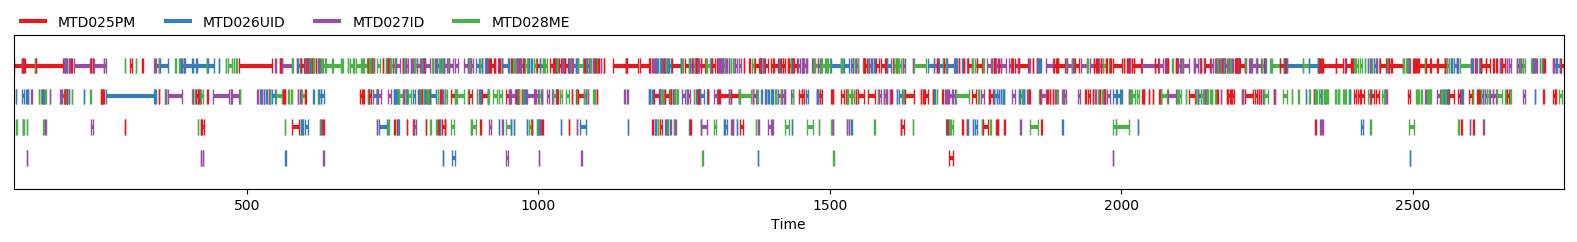

In [32]:
reference

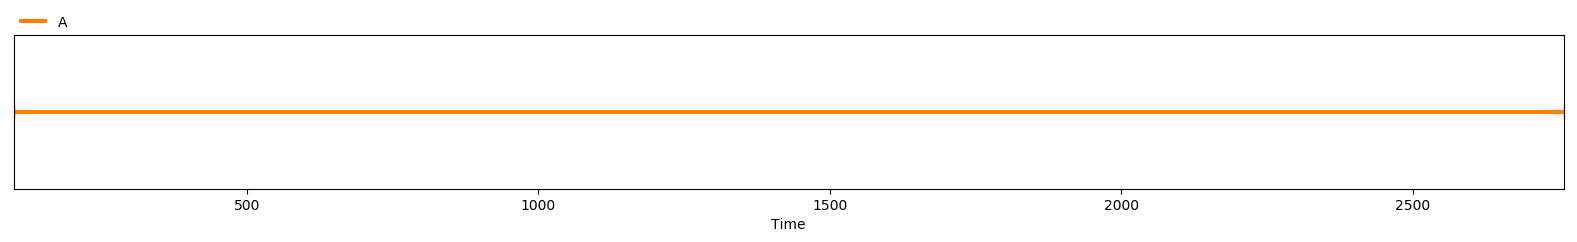

In [59]:
hypothesis.to_annotation()

In [83]:
# Loop on Test Files
from pyannote.database import get_annotated
for test_file in protocol.train():
    # print (test_file)
    # load reference annotation
    reference = test_file['annotation']
    uem = get_annotated(test_file)

    # load precomputed change scores as pyannote.core.SlidingWindowFeature
    scd_scores = precomputed(test_file)

    # binarize scores to obtain speech regions as pyannote.core.Timeline
    hypothesis = peak.apply(scd_scores, dimension=1)

    # evaluate speech activity detection
    metric(reference, hypothesis.to_annotation(), uem=uem)

    purity, coverage, fmeasure = metric.compute_metrics()
    print(f'Purity = {100*purity:.1f}% / Coverage = {100*coverage:.1f}%')

Purity = 39.2% / Coverage = 100.0%
Purity = 39.4% / Coverage = 100.0%
Purity = 39.4% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.7% / Coverage = 100.0%
Purity = 39.7% / Coverage = 100.0%
Purity = 39.7% / Coverage = 100.0%
Purity = 39.8% / Coverage = 100.0%
Purity = 39.8% / Coverage = 100.0%
Purity = 39.8% / Coverage = 100.0%
Purity = 39.8% / Coverage = 100.0%
Purity = 39.8% / Coverage = 100.0%
Purity = 39.7% / Coverage = 100.0%
Purity = 39.7% / Coverage = 100.0%
Purity = 39.7% / Coverage = 100.0%
Purity = 39.7% / Coverage = 100.0%
Purity = 39.6% / Coverage = 100.0%
Purity = 39.6% / Coverage = 100.0%
Purity = 39.6% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Coverage = 100.0%
Purity = 39.5% / Cov

In [84]:
# Peak Detection
from pyannote.audio.signal import Peak
peak = Peak(alpha=0.1, min_duration=1.0, log_scale=True)

# Loop on Test Files
from pyannote.database import get_annotated
for test_file in protocol.train():
    # print (test_file)
    # load reference annotation
    reference = test_file['annotation']
    uem = get_annotated(test_file)

    # load precomputed change scores as pyannote.core.SlidingWindowFeature
    scd_scores = precomputed(test_file)

    # binarize scores to obtain speech regions as pyannote.core.Timeline
    hypothesis = peak.apply(scd_scores, dimension=1)

    # evaluate speech activity detection
    metric(reference, hypothesis.to_annotation(), uem=uem)

    purity, coverage, fmeasure = metric.compute_metrics()
    print(f'Purity = {100*purity:.1f}% / Coverage = {100*coverage:.1f}%')

Purity = 39.5% / Coverage = 99.1%
Purity = 39.8% / Coverage = 98.6%
Purity = 40.0% / Coverage = 98.0%
Purity = 40.3% / Coverage = 97.4%
Purity = 40.5% / Coverage = 96.7%
Purity = 40.9% / Coverage = 95.8%
Purity = 41.1% / Coverage = 95.3%
Purity = 41.2% / Coverage = 94.9%
Purity = 41.4% / Coverage = 94.5%
Purity = 41.6% / Coverage = 94.0%
Purity = 41.7% / Coverage = 93.8%
Purity = 41.8% / Coverage = 93.5%
Purity = 42.0% / Coverage = 93.1%
Purity = 42.1% / Coverage = 92.8%
Purity = 42.2% / Coverage = 92.7%
Purity = 42.3% / Coverage = 92.4%
Purity = 42.4% / Coverage = 92.0%
Purity = 42.5% / Coverage = 91.7%
Purity = 42.6% / Coverage = 91.5%
Purity = 42.7% / Coverage = 91.2%
Purity = 42.9% / Coverage = 90.9%
Purity = 43.0% / Coverage = 90.6%
Purity = 43.0% / Coverage = 90.4%
Purity = 43.1% / Coverage = 90.2%
Purity = 43.3% / Coverage = 89.9%
Purity = 43.3% / Coverage = 89.7%
Purity = 43.4% / Coverage = 89.6%
Purity = 43.5% / Coverage = 89.3%
Purity = 43.6% / Coverage = 89.0%
Purity = 43.8%

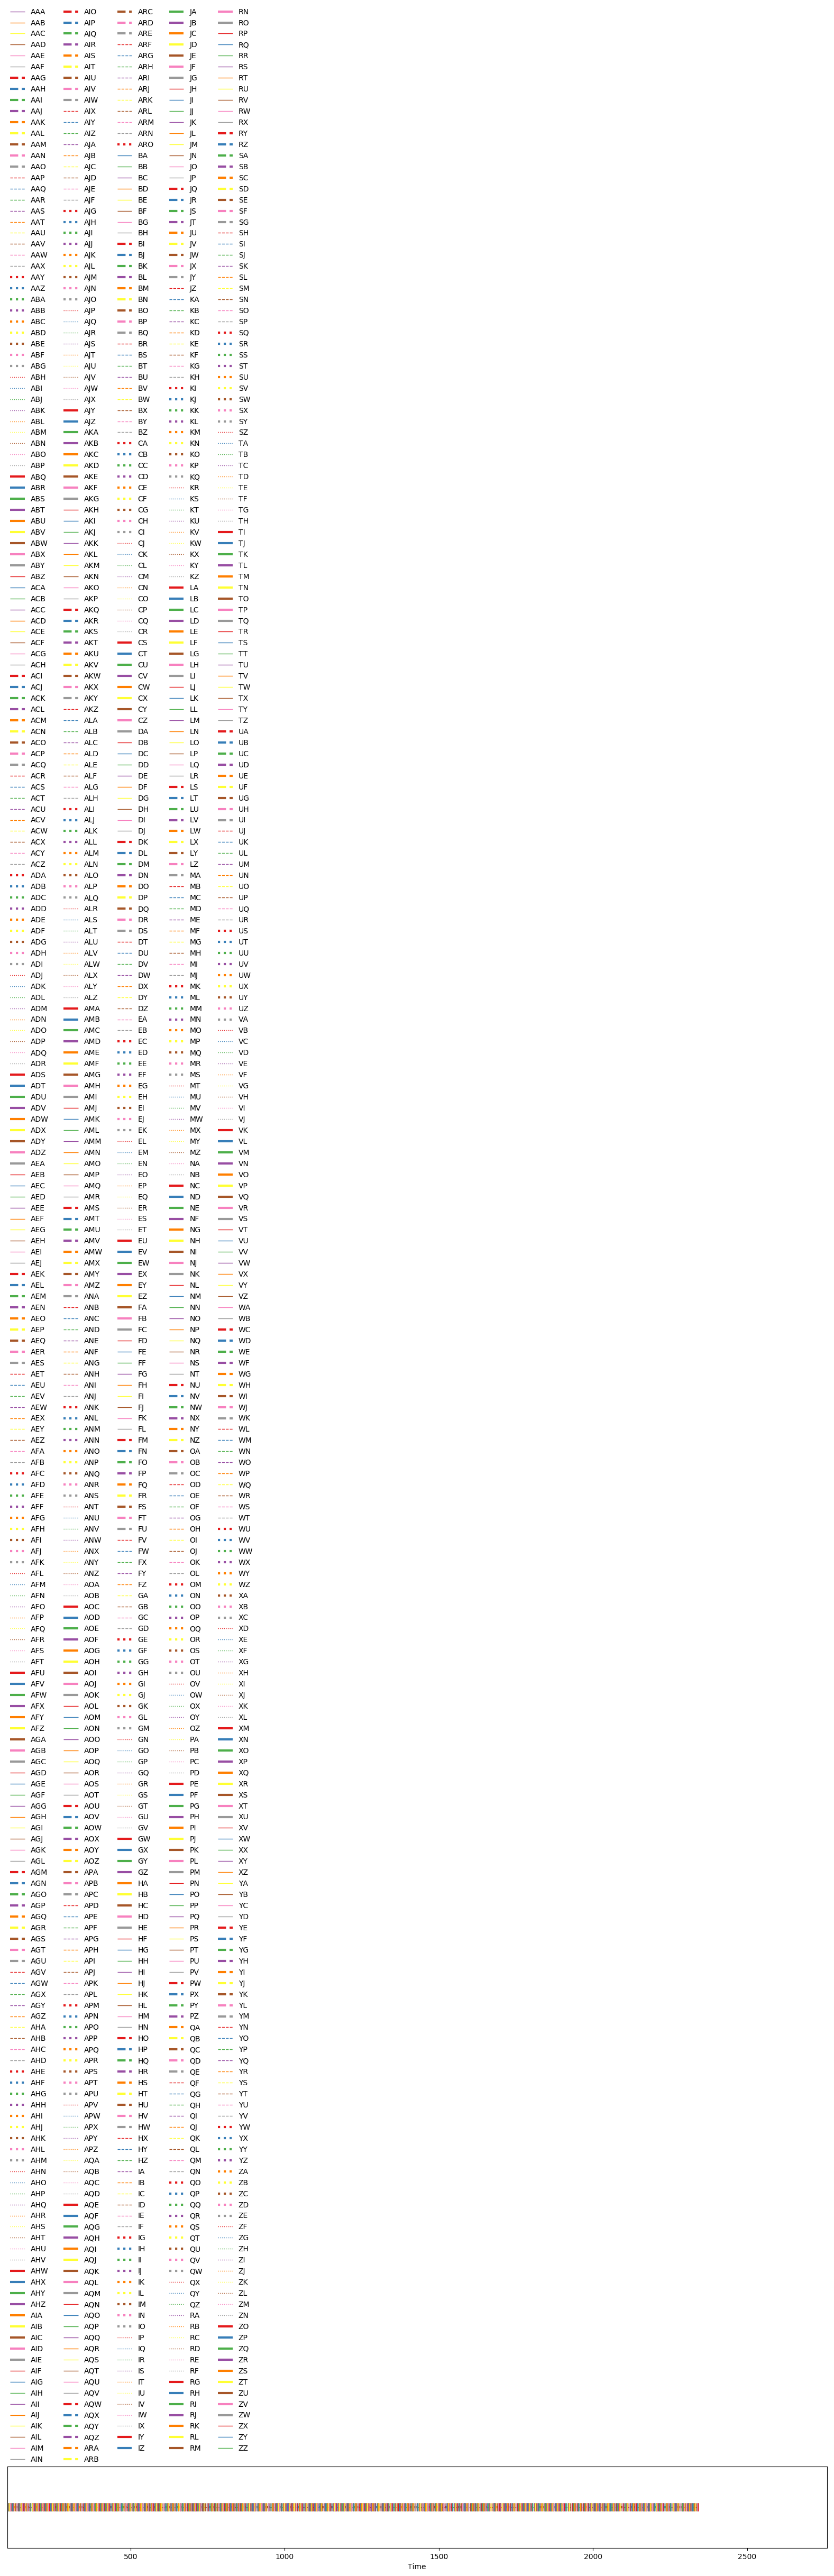

In [85]:
hypothesis.to_annotation()